# SC4001 - Image Captioning Model

#### Run the "Initialization" and "Test with your own image" section if for testing purposes

# Initialization

In [1]:
import json
import os
import pandas as pd
import torch
import random
import gensim
import gensim.downloader as api
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors
from collections import defaultdict 
from skimage.transform import resize
from torch import nn
from PIL import Image

from utils import *
from model import *
from preprocessing import *
from evaluation import *
from dataloader import *
from create_vocab import *


config_path = "config.json"
with open(config_path, "r", encoding="utf8") as f:
    config = json.load(f)

if config["use_gpu"]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f"Using device:{device}")

set_seed(config["seed"])

Using device:cpu


In [2]:
train_path_to_img = config["train_img_path"]
train_annotation_path = config['train_annotation_path']

val_path_to_img = config["val_img_path"]
val_annotation_path = config['val_annotation_path']

path_to_wordVec = config["word_vector_path"]

pad_token = config["pad_token"]
start_token = config["start_token"]
end_token = config["end_token"]
unk_token = config["unk_token"]

batch_size = config["batch_size"]

### Loading DataFrames, Word2Vector and Vocab json files

In [3]:
w2v = gensim.downloader.load('word2vec-google-news-300')
# w2v = KeyedVectors.load_word2vec_format(path_to_wordVec, binary=False,limit = 200000)

In [4]:
# use create_vocab.py to create a vocab file first
# create_vocab()

with open('id_to_token.json', 'r') as json_file:
    id_to_token = json.load(json_file)
    
id_to_token = {int(k): v for k, v in id_to_token.items()}
      
with open('token_to_id.json', 'r') as json_file:
    token_to_id = json.load(json_file) 

### Initializing our Image Caption Model. Our model dimensions, and other variables are found in the config.json

In [5]:
attention_dim = config["model_config"]['attention_dim']
embed_dim = w2v.vector_size
hidden_dim = config["model_config"]['hidden_dim']
dropout = config["model_config"]['dropout']

model = ImageCaptioningModel(
    attention_dim = attention_dim, 
    embed_dim = embed_dim, 
    hidden_dim = hidden_dim, 
    vocab_size = len(id_to_token),
    dropout = dropout,
    id_to_token = id_to_token,
    w2v = w2v
).to(device)

lr = config["train_config"]['learning_rate']
lamda = config["train_config"]['lamda']
max_grad = config["train_config"]['grad_clip']
num_epochs = config["train_config"]['no_of_epochs']

optimizer = torch.optim.Adam(model.parameters(), lr= lr)
loss_fn = nn.CrossEntropyLoss(ignore_index = token_to_id[pad_token])

/Users/yeeksheng/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yeeksheng/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loading the model file that has been trained.

In [6]:
model_filename = 'Image_Captioning_LSTM_Model.pt'

if os.path.exists(model_filename):
    model.load_state_dict(torch.load(model_filename,map_location=device))
    print("Model loaded successfully.")
else:
    print("Model file does not exist, continuing with the current model.")

Model loaded successfully.


# Training our model

### Load training dataset and dataloader

In [5]:
train_dataset = ImageCaptionDataset(train_file_name, train_Y)
train_dataloader = CustomLoader(train_dataset, batch_size= batch_size, shuffle=True)

In [ ]:
train_img_caption_df = get_annotation_img_df(train_path_to_img,train_annotation_path)
train_file_name = train_img_caption_df["file_name"].tolist()
train_Y = train_img_caption_df["caption"].tolist()
train_Y = tokenize(train_Y)

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, max_grad, lamda, token_to_id):    
    model.train()
    size = 0
    num_batches = len(dataloader)
    counter = num_batches//4
    count = 0
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        count+=1
        y, sent_L = sentenceListToTokenTensor(y, token_to_id) 
        X, y, sent_L = batch_sort(X,y,sent_L)
        mask = (y != token_to_id[pad_token]).float().to(device)
        size = size + torch.sum(mask)
        maxL = y.size(1)
        y = y.to(device)
        pred, tokenIDGenerated, alphas = model(X, y, sent_L) 
        pred = pred.to(device)
        y = y[:, 1:]
        loss = loss_fn( pred.view(-1, pred.size(-1)) , torch.reshape(y, (-1, )).to(torch.long).to(device) )
        loss += lamda * ((1 - alphas.sum(dim=1)) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        
        for group in optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.grad.data.clamp_(-max_grad, max_grad)
            
        optimizer.step()
        train_loss += loss.item()
        
        if count % counter == 0:
            model_filename = f'Image_Captioning_LSTM_Model.pt' 
            torch.save(model.state_dict(), model_filename)
        
        print(X[0])
        print(y[0])
        print(tokenIDGenerated[0])
        print("trainloss", loss.item())
        
    train_loss /= num_batches
    return train_loss

In [ ]:
train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
for epoch in range(num_epochs):
    
    train_loss = train_loop(
        dataloader = train_dataloader,
        model = model, 
        loss_fn = loss_fn, 
        optimizer = optimizer,
        max_grad = max_grad,
        lamda = lamda,
        token_to_id = token_to_id
    )
    
    train_loss_.append(train_loss)

    model_filename = f'Image_Captioning_LSTM_Model.pt' 
    torch.save(model.state_dict(), model_filename)

    print(f"Epoch {epoch+1}, train_loss {train_loss:>7f}")

print("Done!")

# Evaluation of our model performance

### We are using validation images and annotations for our model to predict the captions. The predicted captions is then tested against the image annotations.

In [27]:
val_img_caption_df = get_annotation_img_df(val_path_to_img,val_annotation_path)
val_file_name = val_img_caption_df["file_name"].tolist()
val_Y = val_img_caption_df["caption"].tolist()
val_Y = tokenize(val_Y)

In [28]:
X = val_file_name
y = val_Y
combined = list(zip(X, y))
random.shuffle(combined)
X, y = zip(*combined)

sample = 30

In [35]:
val_dataset = ImageCaptionDataset(X[:sample], y[:sample])
val_dataloader = CustomLoader(val_dataset, batch_size=10, shuffle=True)

predList = finalTestBeamSearch(val_dataloader, model, id_to_token, token_to_id, 3, token_to_id[start_token])

### Predicted captions from our model

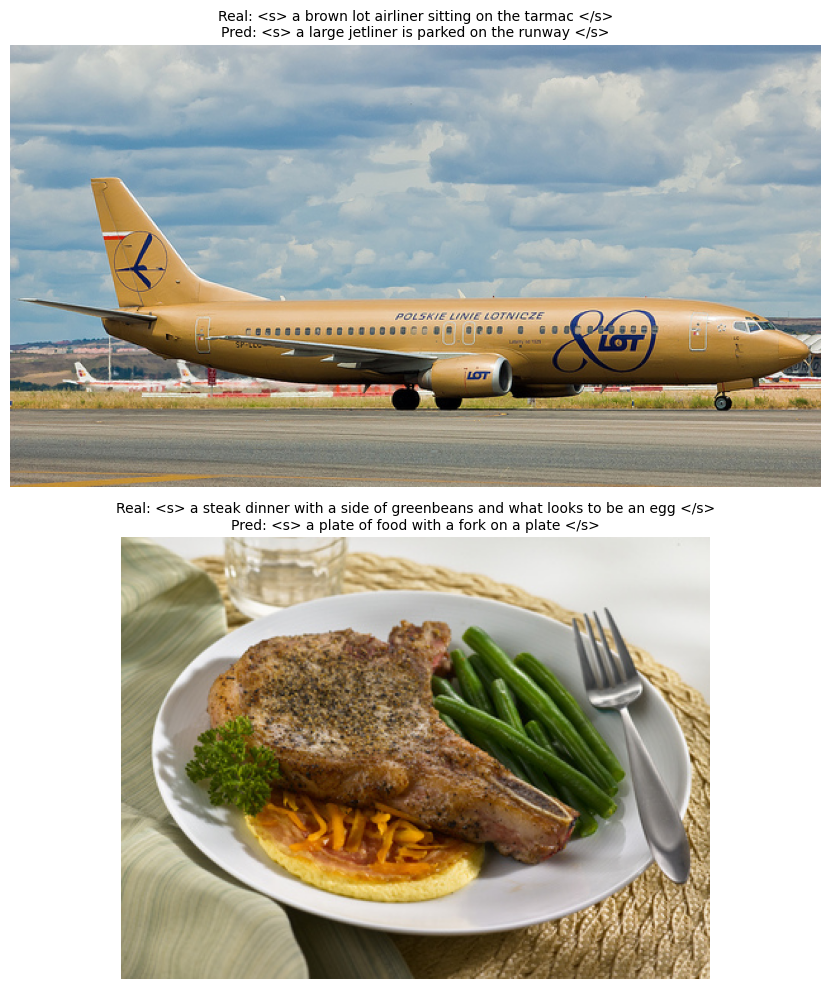

In [20]:
show_predictions_with_image(predList,2)

### Visualising how our decoder uses the attention to predict caption.

Real: <s> a brown lot airliner sitting on the tarmac </s>
Prediction: <s> a large jetliner is parked on the runway </s>


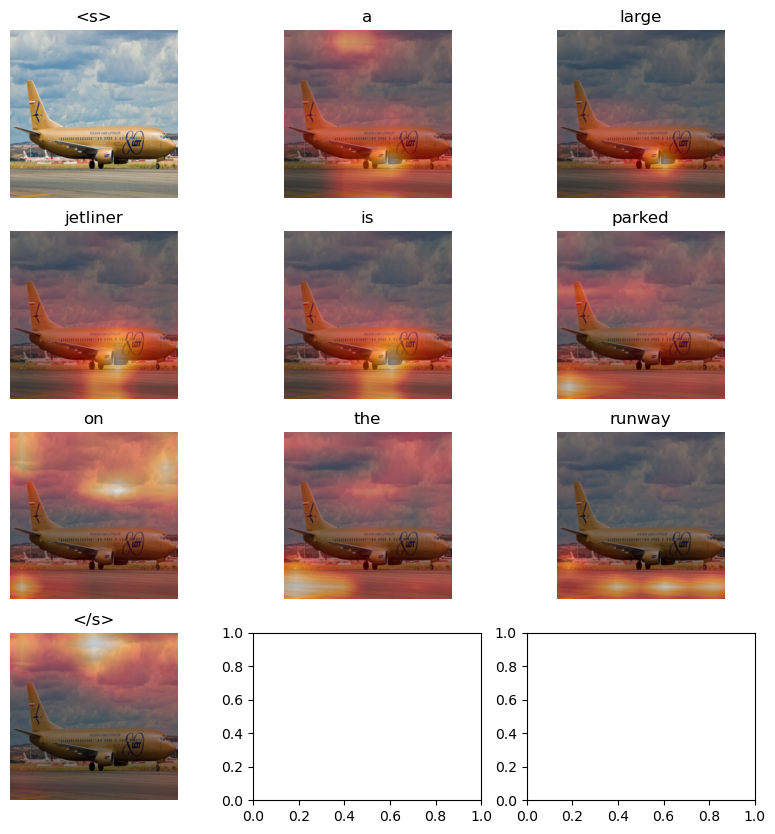

In [21]:
show_attention_map(model, predList[0],id_to_token, token_to_id)

### Using BLEU Score to evaluate the performance of our model. The score ranges from 0 to 1 with 1 being a perfect score.

In [32]:
print("BLEU Score for Validation Images")
BLEU_Score(predList)

BLEU Score for Validation Images
BLEU-1: 0.112805
BLEU-2: 0.006153
BLEU-3: 0.002567
BLEU-4: 0.001561


# Test with your own image
specify your image path and maximum caption length

In [7]:
img_path = 'INSERT UR IMAGE PATH'
caption_length = 20
beam_width = 3

In [8]:
tokenIDGenerated, _ = forwardTestSGD(model, img_path, caption_length, beam_width, token_to_id[start_token])
resultTokens = []
for z in range(len(tokenIDGenerated)):
    token = id_to_token[tokenIDGenerated[z]]
    resultTokens.append(token)

    if token == end_token:
        break

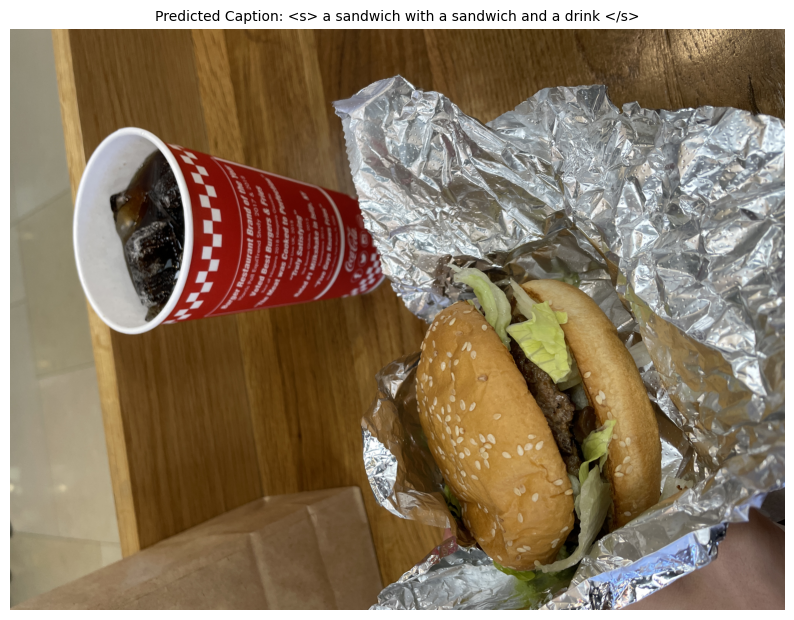

In [9]:
pred = " ".join(resultTokens)
title = "Predicted Caption: " + pred
image = Image.open(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title(title, fontsize=10)

plt.show()